In [2]:
import polars as pl

data = pl.read_csv(
    "./sensor_data_200.txt",
    separator=" ",
    has_header=False,
    new_columns=["date", "time", "ir", "lidar"],
)
data

date,time,ir,lidar
i64,i64,i64,i64
20180122,95819,305,214
20180122,95822,299,211
20180122,95826,292,199
20180122,95829,321,208
20180122,95832,298,212
…,…,…,…
20180124,120023,313,208
20180124,120026,297,200
20180124,120030,323,204


In [3]:
print(data["lidar"][0:5])

shape: (5,)
Series: 'lidar' [i64]
[
	214
	211
	199
	208
	212
]


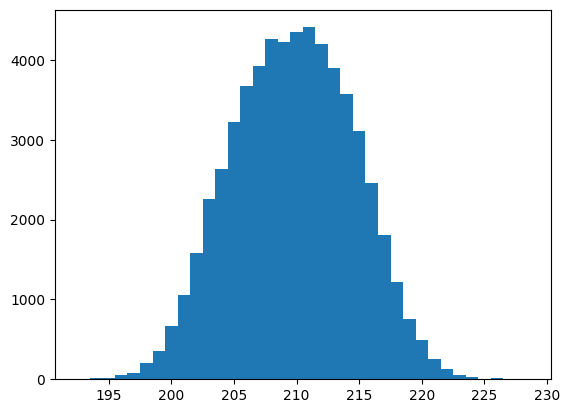

In [4]:
import matplotlib.pyplot as plt
plt.hist(data["lidar"], bins=max(data["lidar"]) - min(data["lidar"]), align="left")
plt.show()

In [5]:
print(data["lidar"].mean())
print(sum(data["lidar"]) / len(data["lidar"]))

209.73713297619855
209.73713297619855


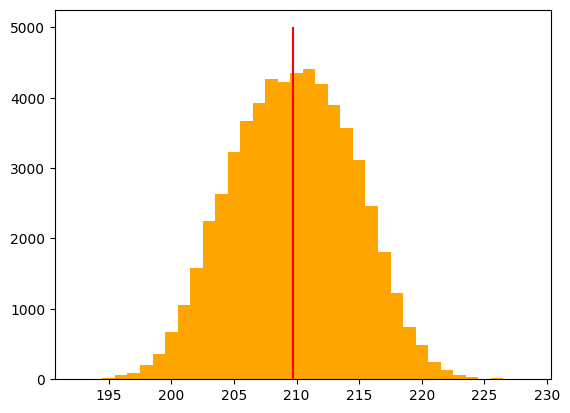

In [6]:
import matplotlib.pyplot as plt
plt.hist(data["lidar"], bins=max(data["lidar"]) - min(data["lidar"]), align="left", color="orange")
plt.vlines(data["lidar"].mean(), ymin=0, ymax=5000, color="red")
plt.show()

In [7]:
# 不偏分散
data["lidar"].var()

23.408106598554685

In [8]:
# 標準偏差
import math
math.sqrt(data["lidar"].var())

4.838192492920748

In [9]:
freqs = pl.DataFrame(data["lidar"].value_counts())
freqs.insert_column(2, (freqs["count"] / len(data["lidar"])).alias("probs"))
print(sum(freqs["probs"]))
freqs.sort("probs", descending=True)

0.9999999999999999


lidar,count,probs
i64,u32,f64
211,4409,0.074744
210,4355,0.073829
208,4261,0.072235
209,4228,0.071676
212,4201,0.071218
…,…,…
195,13,0.00022
194,10,0.00017
193,4,0.000068


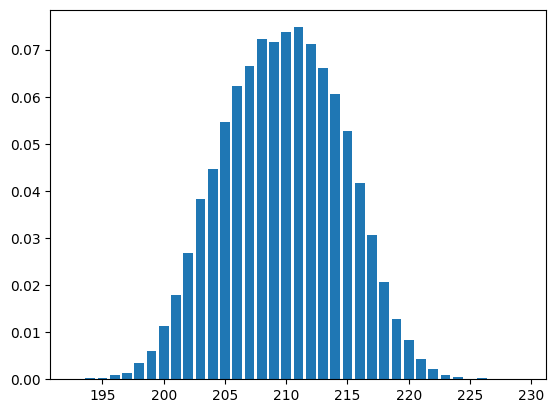

In [10]:
plt.bar(freqs["lidar"], freqs["probs"])
plt.show()

In [11]:
freqs_pd = freqs.to_pandas()
def drawing():
    return freqs_pd.sample(1, weights="probs")["lidar"].values[0]

drawing()

np.int64(216)

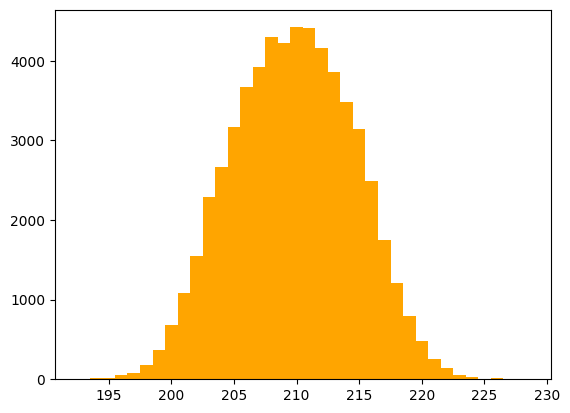

In [12]:
samples = pl.Series([drawing() for _ in range(len(data))]).alias("lidar")
plt.hist(samples, max(samples) - min(samples), color="orange", align="left")
plt.show()

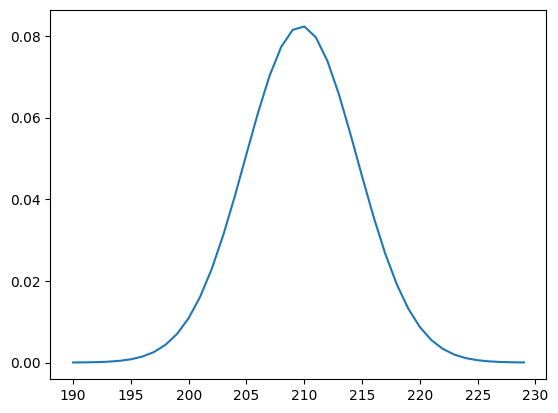

In [13]:
# ガウス分布
# mu: 平均値μ
# sigma_sq: 分散σ^2
def p(z: float, mu: float, sigma_sq: float) -> float:
    return 1 / math.sqrt(2 * math.pi * sigma_sq) * math.exp(-(z-mu) * (z-mu) / (2 * sigma_sq))

mu = data["lidar"].mean()
sigma_sq = data["lidar"].var()

x = range(190, 230)
y = [p(z, mu, sigma_sq) for z in x]
plt.plot(x, y)
plt.show()

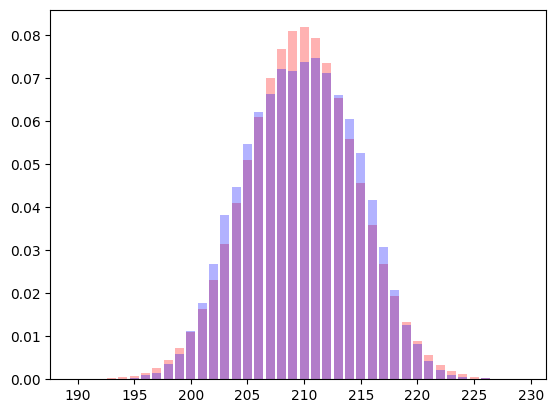

In [14]:
def prob(z: int, mu: float, sigma_sq: float):
    width = 0.5
    return width * (p(z - width, mu, sigma_sq) + p(z + width, mu, sigma_sq))

x = range(190, 230)
y = [prob(z, mu, sigma_sq) for z in x]

plt.bar(x, y, color="red", alpha=0.3)
plt.bar(freqs["lidar"], freqs["probs"], color="blue", alpha=0.3)
plt.show()

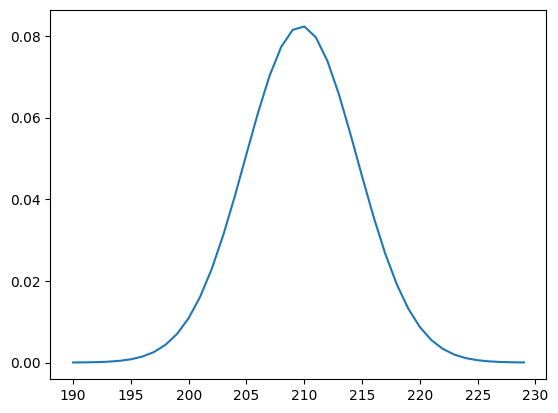

In [15]:
from scipy.stats import norm

x = range(190, 230)
y = [norm.pdf(z, mu, math.sqrt(sigma_sq)) for z in x]

plt.plot(x, y)
plt.show()

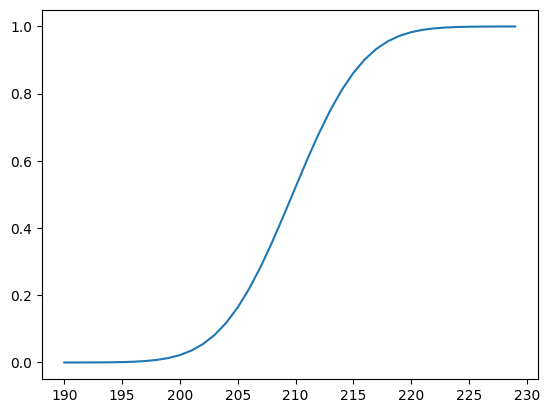

In [16]:
x = range(190, 230)
y = [norm.cdf(z, mu, math.sqrt(sigma_sq)) for z in x]

plt.plot(x, y)
plt.show()

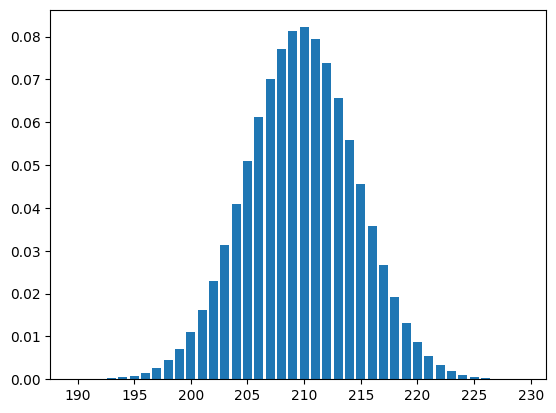

In [17]:
x = range(190, 230)
y = [norm.cdf(z + 0.5, mu, math.sqrt(sigma_sq)) - norm.cdf(z - 0.5, mu, math.sqrt(sigma_sq)) for z in x]

plt.bar(x, y)
plt.show()

In [18]:
import random
samples = [random.choice([1, 2, 3, 4, 5, 6]) for _ in range(10000)]
sum(samples) / len(samples)

3.5093